In [1]:
import pints
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Create own Logistic Model with pints Forward Model
class MyLogisticModel(pints.ForwardModel):
    def __init__(self, initial_population_size=2):
        super(MyLogisticModel, self).__init__()
        self._p0 = float(initial_population_size)

    def n_parameters(self):
        """
        Returns the dimension of the parameter space.
        """
        return 2

    def simulate(self, parameters, times):
        """
        Runs a forward simulation with the given ``parameters`` and returns a
        time-series with data points corresponding to the given ``times``.
        Returns a sequence of length ``n_times`` (for single output problems)
        or a NumPy array of shape ``(n_times, n_outputs)`` (for multi-output
        problems), representing the values of the model at the given ``times``.
        Parameters
        ----------
        parameters
            An ordered sequence of parameter values.
        times
            The times at which to evaluate. Must be an ordered sequence,
            without duplicates, and without negative values.
            All simulations are started at time 0, regardless of whether this
            value appears in ``times``.
        """
        r, k = [float(x) for x in parameters]
        times = np.asarray(times)
        if np.any(times < 0):
            raise ValueError('Negative times are not allowed.')
        if self._p0 == 0 or k < 0:
            return np.zeros(times.shape)

        exp = np.exp(-r * times)
        c = (k / self._p0 - 1)

        values = k / (1 + c * exp)

        return values
        

    def n_outputs(self):

        """
        Returns the number of outputs this model has. The default is 1.
        """
        return 1


In [3]:
# Create logistic model
model = MyLogisticModel()

# Select the parameters to run the model to obtain data
true_parameters = [0.015, 500]

# Run the model for the `times` timeframe
times = np.linspace(0, 1000, 400)

# Run deterministic model with true parameters
org_values = model.simulate(true_parameters, times)

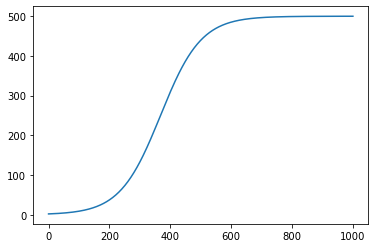

In [4]:
plt.plot(times, org_values)

In [5]:
# Add noise over the smooth data (here is Gaussian noise)
noise = 25
values = org_values + np.random.normal(0, noise, org_values.shape)

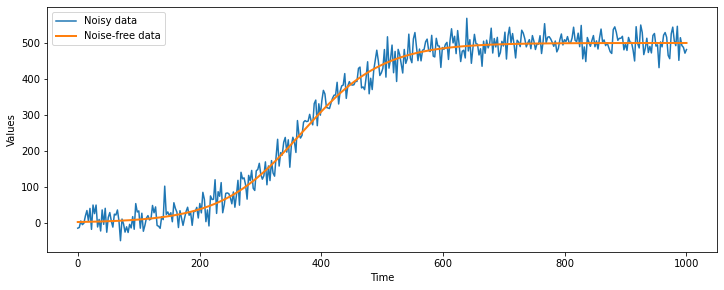

In [6]:
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

We set up the inference for this logistic model

In [7]:
# Set up my log-likelihood object for the inference using the pints.LogPDF
class MyGaussianLogLikelihood(pints.LogPDF):
    r"""
    Calculates a log-likelihood assuming independent Gaussian noise at each
    time point, and adds a parameter representing the standard deviation
    (sigma) of the noise on each output.
    For a noise level of ``sigma``, the likelihood becomes:
    .. math::
        L(\theta, \sigma|\boldsymbol{x})
            = p(\boldsymbol{x} | \theta, \sigma)
            = \prod_{j=1}^{n_t} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(
                -\frac{(x_j - f_j(\theta))^2}{2\sigma^2}\right)
    leading to a log likelihood of:
    .. math::
        \log{L(\theta, \sigma|\boldsymbol{x})} =
            -\frac{n_t}{2} \log{2\pi}
            -n_t \log{\sigma}
            -\frac{1}{2\sigma^2}\sum_{j=1}^{n_t}{(x_j - f_j(\theta))^2}
    where ``n_t`` is the number of time points in the series, ``x_j`` is the
    sampled data at time ``j`` and ``f_j`` is the simulated data at time ``j``.
    For a system with ``n_o`` outputs, this becomes
    .. math::
        \log{L(\theta, \sigma|\boldsymbol{x})} =
            -\frac{n_t n_o}{2}\log{2\pi}
            -\sum_{i=1}^{n_o}{ {n_t}\log{\sigma_i} }
            -\sum_{i=1}^{n_o}{\left[
                \frac{1}{2\sigma_i^2}\sum_{j=1}^{n_t}{(x_j - f_j(\theta))^2}
             \right]}
    Extends :class:`ProblemLogLikelihood`.
    Parameters
    ----------
    problem
        A :class:`SingleOutputProblem` or :class:`MultiOutputProblem`. For a
        single-output problem a single parameter is added, for a multi-output
        problem ``n_outputs`` parameters are added.
    """

    def __init__(self, times):
        super(MyGaussianLogLikelihood, self).__init__()

        # Get number of times, number of outputs
        self._times = times.tolist()
        self._nt = len(self._times)
        self._no = 1

        # Add parameters to problem
        self._n_parameters = 2 + self._no

        # Pre-calculate parts
        self._logn = 0.5 * self._nt * np.log(2 * np.pi)

    def __call__(self, x):
        sigma = np.asarray(x[-self._no:])
        if any(sigma <= 0):
            return -np.inf
        error = self._values - self.evaluate(x[:-self._no])
        return np.sum(- self._logn - self._nt * np.log(sigma)
                      - np.sum(error**2, axis=0) / (2 * sigma**2))

    def _evaluate(self, parameters):
        """
        Runs a simulation using the given parameters, returning the simulated
        values as a NumPy array of shape ``(n_times,)``.
        """
        y = np.asarray(self._model.simulate(parameters, self._times))
        return y.reshape((self._n_times,))

    def n_parameters(self):
        """
        Returns the dimension of the parameter space.
        """
        return self._n_parameters

log_likelihood = MyGaussianLogLikelihood(times)

In [8]:
# Add noise to the paramaters of the inference problem
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 25]


Create LogPrior and add LogLikelihood to create the LogPosterior

In [9]:
log_prior = pints.UniformLogPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

In [10]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [11]:
# Starting points for the inference
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [12]:
# Run the in ference for the initial guesses
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.


AttributeError: 'MyGaussianLogLikelihood' object has no attribute '_values'